# **Collaborative Filtering**

# **Dataset Description: `ratings2k.csv`**
**This dataset contains product rating information, with 2365 data samples and the following columns:**

| Column Name | Description             | Data Type | Example     |
|-------------|--------------------------|-----------|-------------|
| `index`     | Row index                | Integer   | 0, 1, 2...   |
| `user`      | User ID                  | String    | 73, 36, 72...  |
| `item`      | Product ID               | String    | 52, 239, 26...  |
| `rating`    | Rating (from 0.0 to 5.0) | Float     | 4, 3, 1...    |


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pyspark py4j

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, sqrt, sum as spark_sum, pow as spark_pow, abs as spark_abs, lit, when, expr
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType
from pyspark.sql import Row
from pyspark.sql.functions import col, row_number
from pyspark.sql.window import Window
import matplotlib.pyplot as plt

## **Algorithms**
Implement the Collaborative Filtering algorithm to recommend items for individual

users using PySpark. It should be a class for future deployment.
The similarity between users is measured using the Pearson correlation coefficient.

The constructor takes in the value of N (number of similar users) and the data set as a data frame (PySpark).

The function predict() takes in a user (a vector of ratings) and the expected number of recommended items. It returns a data frame (PySpark) consisting of recommended items sorted in the descending order of scores.

## **Experiments**
Load the given dataset to construct the utility matrix and then infer “profile” vectors for users and items.

Divide the dataset into a training and test sets with the ratio of 8 : 2.

Evaluate the algorithm in the test set with N in the range [2, 16]. After that, draw a bar chart to illustrate the RMSE values for each N.

### **Lớp `CollaborativeFiltering`: Dự đoán đánh giá bằng lọc cộng tác dựa trên Pearson**

Chuẩn hóa đánh giá để tính Pearson giữa người dùng.

Chọn Top-N người dùng tương tự nhất cho mỗi người dùng cần dự đoán.

Dự đoán đánh giá dựa trên đánh giá của hàng xóm có trọng số theo độ tương quan.

In [ ]:
class CollaborativeFiltering:
    def __init__(self, df, N, similarity_threshold):
        self.spark = df.sparkSession
        self.df = df  # Dữ liệu đánh giá đầu vào
        self.N = N  # Số lượng hàng xóm tương tự
        self.similarity_threshold = similarity_threshold  # Ngưỡng tương quan Pearson
        self._prepare()  # Chuẩn bị dữ liệu và tính toán tương đồng

    def _prepare(self):
        # Tính trung bình rating của mỗi người dùng
        self.user_avg = self.df.groupBy("user").agg(avg("rating").alias("avg_rating"))

        # Chuẩn hóa rating bằng cách trừ trung bình của người dùng
        normalized = self.df.join(self.user_avg, "user")\
                           .withColumn("norm_rating", col("rating") - col("avg_rating"))

        # Tạo cặp người dùng có cùng item
        pair_ratings = normalized.alias("a").join(
            normalized.alias("b"),
            (col("a.item") == col("b.item")) & (col("a.user") < col("b.user")),
            "inner"
        )

        # Tính các thành phần cho công thức tương quan Pearson
        pair_scores = pair_ratings.select(
            col("a.user").alias("user1"),
            col("b.user").alias("user2"),
            (col("a.norm_rating") * col("b.norm_rating")).alias("product"),
            col("a.norm_rating").alias("r1"),
            col("b.norm_rating").alias("r2")
        )

        # Tính hệ số tương quan Pearson và chỉ chọn các cột cần thiết
        similarity_df = pair_scores.groupBy("user1", "user2").agg(
            spark_sum("product").alias("numerator"),
            sqrt(spark_sum(col("r1")**2)).alias("denom1"),
            sqrt(spark_sum(col("r2")**2)).alias("denom2")
        ).withColumn(
            "pearson",
            when(col("denom1") * col("denom2") > 0, col("numerator") / (col("denom1") * col("denom2"))).otherwise(0.0)
        ).filter(col("pearson").isNotNull())\
         .select("user1", "user2", "pearson")

        # Tạo bản sao đối xứng để đảm bảo ma trận tương đồng đối xứng
        similarity_mirror = similarity_df.select(
            col("user2").alias("user1"),
            col("user1").alias("user2"),
            col("pearson")
        )

        # Thêm tự tương quan (pearson = 1.0 cho cùng người dùng)
        self_similarity = self.df.select("user").distinct().withColumn(
            "user2", col("user")
        ).withColumn("pearson", lit(1.0))

        # Kết hợp tất cả vào ma trận tương đồng
        self.similarity_df = similarity_df.union(similarity_mirror).union(self_similarity)

    def predict(self, test_df, num_recommendations):
        # Lấy danh sách người dùng và item trong tập kiểm tra
        test_users = test_df.select("user").distinct()
        test_items = test_df.select("item").distinct().alias("test_items")

        # Tìm người dùng tương tự với pearson > ngưỡng
        sim_df = test_users.join(
            self.similarity_df,
            test_users.user == self.similarity_df.user1,
            "inner"
        ).select(
            col("user1").alias("target_user"),
            col("user2"),
            col("pearson")
        )

        # Lấy top-N người dùng tương tự
        window_spec = Window.partitionBy("target_user").orderBy(col("pearson").desc())
        topN_sim_df = sim_df.withColumn("rank", row_number().over(window_spec))\
                            .filter((col("rank") <= self.N) & (col("pearson") > self.similarity_threshold))\
                            .drop("rank").alias("topN_sim")

        # Ghép với đánh giá của người dùng tương tự, chỉ lấy item trong tập kiểm tra
        sim_ratings = topN_sim_df.join(
            self.df.alias("ratings"),
            col("ratings.user") == col("topN_sim.user2"),
            "inner"
        ).join(
            test_items,
            col("ratings.item") == col("test_items.item"),
            "inner"
        ).join(
            self.user_avg.withColumnRenamed("user", "sim_user").withColumnRenamed("avg_rating", "sim_user_avg").alias("user_avg"),
            col("topN_sim.user2") == col("user_avg.sim_user"),
            "inner"
        ).select(
            col("target_user"),
            col("ratings.item").alias("item"),  # Chọn rõ ràng item từ ratings
            col("ratings.rating").alias("rating"),
            col("pearson"),
            col("sim_user_avg")
        )

        # Tính rating chuẩn hóa và dự đoán
        norm_preds = sim_ratings.withColumn(
            "norm_rating", col("rating") - col("sim_user_avg")
        ).withColumn(
            "weighted", col("norm_rating") * col("pearson")
        ).groupBy("target_user", "item").agg(
            spark_sum("weighted").alias("numerator"),
            spark_sum(spark_abs(col("pearson"))).alias("denominator")
        ).filter(col("denominator") > 0)\
         .withColumn("predicted_norm_rating", col("numerator") / col("denominator"))

        # Cộng lại trung bình của người dùng đích để khôi phục rating
        preds = norm_preds.join(
            self.user_avg.withColumnRenamed("user", "target_user").alias("target_avg"),
            "target_user",
            "inner"
        ).withColumn(
            "predicted_rating",
            col("predicted_norm_rating") + col("avg_rating")
        ).select(
            col("target_user").alias("user"),
            "item",
            "predicted_rating"
        )

        # Lấy top-N item được dự đoán cao nhất cho mỗi người dùng
        rank_spec = Window.partitionBy("user").orderBy(col("predicted_rating").desc())
        topN_preds = preds.withColumn("rank", row_number().over(rank_spec))\
                          .filter(col("rank") <= num_recommendations)\
                          .drop("rank")

        return topN_preds


### **Hàm `compute_rmse`: Đánh giá mô hình bằng RMSE**
Tính sai số căn phương bình phương trung bình (Root Mean Squared Error – RMSE) giữa giá trị dự đoán và thực tế.

In [ ]:
def compute_rmse(pred_df, test_df):
    # Tính RMSE bằng cách so sánh dự đoán và giá trị thực tế
    joined = pred_df.join(
        test_df.select("user", "item", "rating"),
        on=["user", "item"],
        how="inner"
    ).withColumn(
        "squared_error", spark_pow(col("predicted_rating") - col("rating"), 2)
    )
    rmse = joined.select(sqrt(avg("squared_error")).alias("rmse")).collect()[0]["rmse"]
    print(f"Số lượng dự đoán dùng để tính RMSE: {joined.count()}")
    return rmse

### **Khởi tạo SparkSession và đọc dữ liệu**

SparkSession được tạo với tên ứng dụng là "CollaborativeFiltering_Pearson".

Dữ liệu được đọc từ Google Drive với tùy chọn header=True để sử dụng dòng đầu làm tiêu đề, và inferSchema=True để tự động suy luận kiểu dữ liệu.

Chỉ giữ lại 3 cột: user, item và rating để phục vụ cho bài toán Collaborative Filtering.


In [ ]:
# Khởi tạo SparkSession
spark = SparkSession.builder.appName("CollaborativeFiltering").getOrCreate()

# Đọc dữ liệu từ ratings2k.csv
data = spark.read.csv("/content/drive/MyDrive/ratings2k.csv", header=True, inferSchema=True)


In [ ]:
# Chia tập dữ liệu thành tập huấn luyện và kiểm tra
train_df, test_df = data.randomSplit([0.8, 0.2], seed=42)
print(f"Kích thước tập huấn luyện: {train_df.count()}")
print(f"Kích thước tập kiểm tra: {test_df.count()}")

# Đánh giá mô hình với N từ 2 đến 16
rmse_results = []
for N in range(2, 17):
    print(f"\nĐánh giá với N = {N}")
    model = CollaborativeFiltering(train_df, N, similarity_threshold=0.5)
    pred_df = model.predict(test_df, num_recommendations=5)
    rmse = compute_rmse(pred_df, test_df)
    print(f"RMSE = {rmse:.4f}")
    rmse_results.append((N, rmse))

best_N, best_rmse = min(rmse_results, key=lambda x: x[1])
print(f"\nGiá trị N tối ưu là {best_N} với RMSE thấp nhất = {best_rmse:.4f}")


Kích thước tập huấn luyện: 1949
Kích thước tập kiểm tra: 416

Đánh giá với N = 2
Số lượng dự đoán dùng để tính RMSE: 8
RMSE = 0.9672

Đánh giá với N = 3
Số lượng dự đoán dùng để tính RMSE: 10
RMSE = 1.0886

Đánh giá với N = 4
Số lượng dự đoán dùng để tính RMSE: 12
RMSE = 1.0012

Đánh giá với N = 5
Số lượng dự đoán dùng để tính RMSE: 9
RMSE = 0.7362

Đánh giá với N = 6
Số lượng dự đoán dùng để tính RMSE: 7
RMSE = 1.3611

Đánh giá với N = 7
Số lượng dự đoán dùng để tính RMSE: 9
RMSE = 1.3853

Đánh giá với N = 8
Số lượng dự đoán dùng để tính RMSE: 9
RMSE = 1.4751

Đánh giá với N = 9
Số lượng dự đoán dùng để tính RMSE: 11
RMSE = 1.4260

Đánh giá với N = 10
Số lượng dự đoán dùng để tính RMSE: 10
RMSE = 1.8052

Đánh giá với N = 11
Số lượng dự đoán dùng để tính RMSE: 14
RMSE = 1.6197

Đánh giá với N = 12
Số lượng dự đoán dùng để tính RMSE: 13
RMSE = 1.5140

Đánh giá với N = 13
Số lượng dự đoán dùng để tính RMSE: 13
RMSE = 1.4667

Đánh giá với N = 14
Số lượng dự đoán dùng để tính RMSE: 12
RMSE

### **DEMO PREDICTION FOR SPECIFIC USERS**

In [ ]:
# Lấy danh sách người dùng từ test_df thay vì cố định 1, 2, 3
test_users = [row["user"] for row in test_df.select("user").distinct().limit(3).collect()]
print(f"Người dùng được chọn từ test_df: {test_users}")

# Lấy top-N là giá trị có RMSE thấp nhất
best_N = min(rmse_results, key=lambda x: x[1])[0]
print("\n--- DEMO DỰ ĐOÁN CHO NGƯỜI DÙNG CỤ THỂ ---\n")

model = CollaborativeFiltering(train_df, best_N, similarity_threshold=0.3)  # Giảm ngưỡng
pred_df = model.predict(test_df, num_recommendations=10)  # Dự đoán nhiều hơn để loại bỏ trùng

# Lặp qua các người dùng từ test_df
for user_id in test_users:
    print(f"Gợi ý cho người dùng {user_id}:")

    # Lấy các đánh giá thực tế của người dùng từ tập kiểm tra, fallback sang train_df
    user_ratings = test_df.filter(col("user") == user_id)
    if user_ratings.count() == 0:
        user_ratings = train_df.filter(col("user") == user_id)
        print("Không tìm thấy đánh giá trong tập kiểm tra, sử dụng đánh giá từ tập huấn luyện.")
    num_rated = user_ratings.count()
    print(f"Người dùng đã đánh giá {num_rated} item")

    if num_rated > 0:
        print("Mẫu đánh giá của người dùng:")
        user_ratings.select("item", "rating").show(3, truncate=False)
    else:
        print("Không tìm thấy đánh giá nào.")

    # Lấy danh sách item đã đánh giá để loại khỏi gợi ý
    rated_items = [row["item"] for row in user_ratings.select("item").collect()]

    # Gợi ý các item chưa đánh giá (đã loại trừ) và in top 5
    recs = pred_df.filter(
        (col("user") == user_id) & (~col("item").isin(rated_items))
    ).orderBy(col("predicted_rating").desc())

    if recs.count() == 0:
        print("Không có gợi ý nào cho người dùng này do thiếu dữ liệu hoặc không có người dùng tương tự.")
    else:
        print("\nTop 5 item được gợi ý:")
        recs.select("item", "predicted_rating").show(5, truncate=False)

    print("-" * 40)

# Dừng SparkSession
spark.stop()

Người dùng được chọn từ test_df: [31, 65, 53]

--- DEMO DỰ ĐOÁN CHO NGƯỜI DÙNG CỤ THỂ ---

Gợi ý cho người dùng 31:
Người dùng đã đánh giá 16 item
Mẫu đánh giá của người dùng:
+----+------+
|item|rating|
+----+------+
|216 |2.5   |
|26  |3.5   |
|379 |2.5   |
+----+------+
only showing top 3 rows


Top 5 item được gợi ý:
+----+----------------+
|item|predicted_rating|
+----+----------------+
|422 |4.0             |
|462 |3.5             |
|8   |3.5             |
|258 |3.5             |
|77  |3.5             |
+----+----------------+
only showing top 5 rows

----------------------------------------
Gợi ý cho người dùng 65:
Người dùng đã đánh giá 1 item
Mẫu đánh giá của người dùng:
+----+------+
|item|rating|
+----+------+
|176 |1.0   |
+----+------+

Không có gợi ý nào cho người dùng này do thiếu dữ liệu hoặc không có người dùng tương tự.
----------------------------------------
Gợi ý cho người dùng 53:
Người dùng đã đánh giá 1 item
Mẫu đánh giá của người dùng:
+----+------+
|item|ratin

### **Trực quan hóa mối quan hệ giữa số hàng xóm (N) và sai số RMSE**

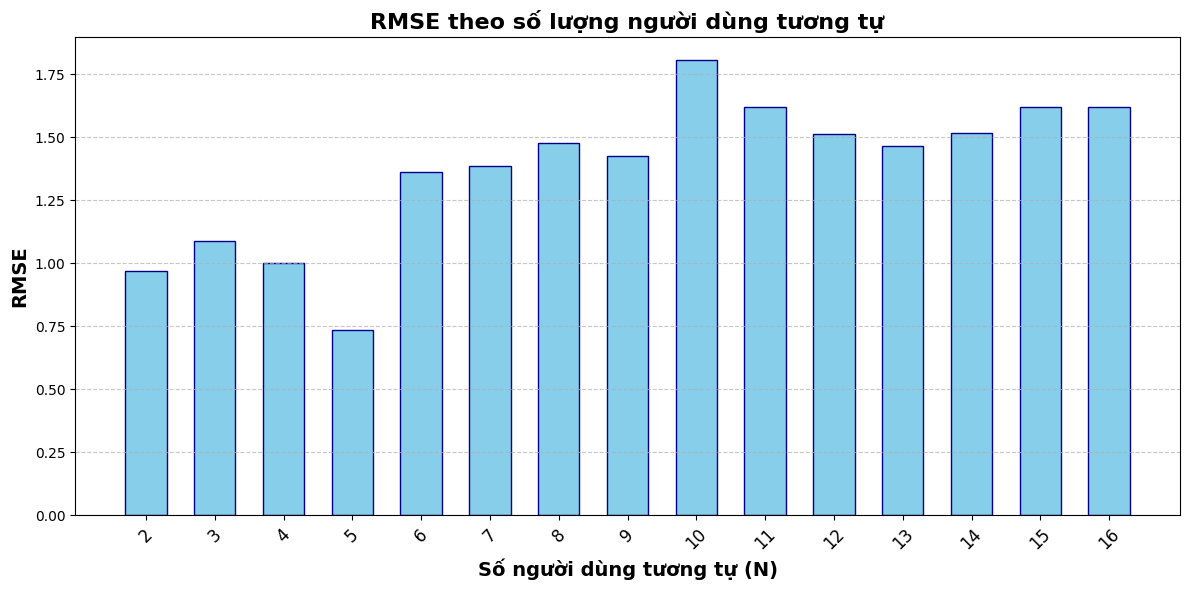

In [ ]:
# Dữ liệu từ kết quả RMSE
ns, rmses = zip(*rmse_results)

plt.figure(figsize=(12, 6))

plt.bar(ns, rmses, color="skyblue", width=0.6, edgecolor='darkblue')

# Thiết lập nhãn cho các trục
plt.xlabel("Số người dùng tương tự (N)", fontsize=14, fontweight='bold')
plt.ylabel("RMSE", fontsize=14, fontweight='bold')

# Thiết lập tiêu đề
plt.title("RMSE theo số lượng người dùng tương tự", fontsize=16, fontweight='bold')

# Điều chỉnh nhãn trục x và đường lưới
plt.xticks(ns, fontsize=12, rotation=45)
plt.grid(axis="y", linestyle='--', alpha=0.7)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()
